In [1]:
!pip install pandas_ta yfinance tensorflow scikit-learn matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 3.1 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of tensorflow to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.3/240.3 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 56.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 620.7/620.7 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 104.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 118.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 135.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 MB 18.0 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled nu

In [1]:
import yfinance as yf
import pandas as pd
import pandas_ta as ta
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

np.random.seed(42)
try:
    import tensorflow as tf
    tf.random.set_seed(42)
except ImportError:
    pass

In [2]:
ticker = "XU100.IS"
start_date = "2019-01-01"
end_date = "2025-01-01"

print(f"Downloading data for {ticker} from {start_date} to {end_date}...")
df = yf.download(ticker, start=start_date, end=end_date)

if isinstance(df.columns, pd.MultiIndex):
    try:
        df.columns = df.columns.get_level_values(0)
    except IndexError:
         pass

if df.empty:
    raise ValueError("No data downloaded. Please check internet connection or ticker symbol.")

print(f"Data Downloaded. Shape: {df.shape}")
df.head()

/tmp/ipython-input-3866021221.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed

Data Downloaded. Shape: (1496, 5)


Price,Close,High,Low,Open,Volume
Date,,,,,
2019-01-02,888.645325,909.856211,886.499340,909.856211,74791250000
2019-01-03,873.985352,895.441231,873.985352,883.754282,93099140000
2019-01-04,888.303284,891.206283,878.937366,878.937366,89073780000
2019-01-07,899.506226,902.274216,892.803258,894.442288,94240720000
2019-01-08,906.965149,907.756160,893.619273,902.474206,95220020000


In [3]:
df['SMA_10'] = ta.sma(df['Close'], length=10)
df['SMA_50'] = ta.sma(df['Close'], length=50)
df['SMA_200'] = ta.sma(df['Close'], length=200)

df['RSI_14'] = ta.rsi(df['Close'], length=14)

macd = ta.macd(df['Close'])
df = pd.concat([df, macd], axis=1)

df['Target'] = df['Close'].shift(-1)

df.interpolate(method='linear', inplace=True)
df.dropna(inplace=True)

feature_cols = ['Close', 'SMA_10', 'SMA_50', 'SMA_200', 'RSI_14']
macd_cols = [c for c in df.columns if 'MACD' in c]
feature_cols.extend(macd_cols)

print(f"Selected Features: {feature_cols}")

X = df[feature_cols].values
y = df['Target'].values.reshape(-1, 1)

scaler_X = MinMaxScaler(feature_range=(0, 1))
X_scaled = scaler_X.fit_transform(X)

scaler_y = MinMaxScaler(feature_range=(0, 1))
y_scaled = scaler_y.fit_transform(y)

split_idx = int(len(X_scaled) * 0.8)

X_train, X_test = X_scaled[:split_idx], X_scaled[split_idx:]
y_train, y_test = y_scaled[:split_idx], y_scaled[split_idx:]

print(f"Training Samples: {X_train.shape[0]}, Test Samples: {X_test.shape[0]}")

Selected Features: ['Close', 'SMA_10', 'SMA_50', 'SMA_200', 'RSI_14', 'MACD_12_26_9', 'MACDh_12_26_9', 'MACDs_12_26_9']
Training Samples: 1037, Test Samples: 260


In [ ]:
models = {}
predictions = {}

print("Training Linear Regression...")
lr = LinearRegression()
lr.fit(X_train, y_train)
pred_lr = lr.predict(X_test)
models['Linear Regression'] = lr
predictions['Linear Regression'] = pred_lr

print("Training Decision Tree...")
dt = DecisionTreeRegressor(random_state=42)
dt.fit(X_train, y_train)
pred_dt = dt.predict(X_test).reshape(-1, 1)
models['Decision Tree'] = dt
predictions['Decision Tree'] = pred_dt

print("Training Random Forest...")
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train.ravel())
pred_rf = rf.predict(X_test).reshape(-1, 1)
models['Random Forest'] = rf
predictions['Random Forest'] = pred_rf

Training Linear Regression...
Training Decision Tree...
Training Random Forest...


In [ ]:
def create_sequences(data, target, time_steps=60):
    Xs, ys = [], []
    for i in range(len(data) - time_steps):
        Xs.append(data[i:(i + time_steps)])
        ys.append(target[i + time_steps])
    return np.array(Xs), np.array(ys)

X_seq, y_seq = create_sequences(X_scaled, y_scaled, time_steps=60)

split_seq = int(len(X_seq) * 0.8)
X_train_lstm, X_test_lstm = X_seq[:split_seq], X_seq[split_seq:]
y_train_lstm, y_test_lstm = y_seq[:split_seq], y_seq[split_seq:]

print(f"LSTM Train Shape: {X_train_lstm.shape}, LSTM Test Shape: {X_test_lstm.shape}")

model_lstm = Sequential()
model_lstm.add(LSTM(50, return_sequences=True, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
model_lstm.add(Dropout(0.2))
model_lstm.add(LSTM(50, return_sequences=False))
model_lstm.add(Dropout(0.2))
model_lstm.add(Dense(25))
model_lstm.add(Dense(1))

model_lstm.compile(optimizer='adam', loss='mean_squared_error')

print("Training LSTM...")
history = model_lstm.fit(X_train_lstm, y_train_lstm, batch_size=32, epochs=50, verbose=1)

pred_lstm = model_lstm.predict(X_test_lstm)
predictions['LSTM'] = pred_lstm

LSTM Train Shape: (989, 60, 8), LSTM Test Shape: (248, 60, 8)
Training LSTM...
Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 15s 48ms/step - loss: 0.0351
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 0.0036
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - loss: 0.0019
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 0.0020
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 0.0017
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 0.0012
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 0.0016
Epoch 8/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 0.0013
Epoch 9/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - loss: 0.0011
Epoch 10/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 0.0011
Epoch 11/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 0.0012
Epoch 12/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 9.8962e-04
Epoch 13/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 0.0011
Epoch 14/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 8.1158e-04
Epoch 15/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - loss: 8.5729e-04
Ep


--- Model Performance Metrics ---
Linear Regression -> RMSE: 154.5876, R2 Score: 0.9698
Decision Tree -> RMSE: 1432.9301, R2 Score: -1.5932
Random Forest -> RMSE: 1472.2565, R2 Score: -1.7375
LSTM -> RMSE: 511.0513, R2 Score: 0.5905


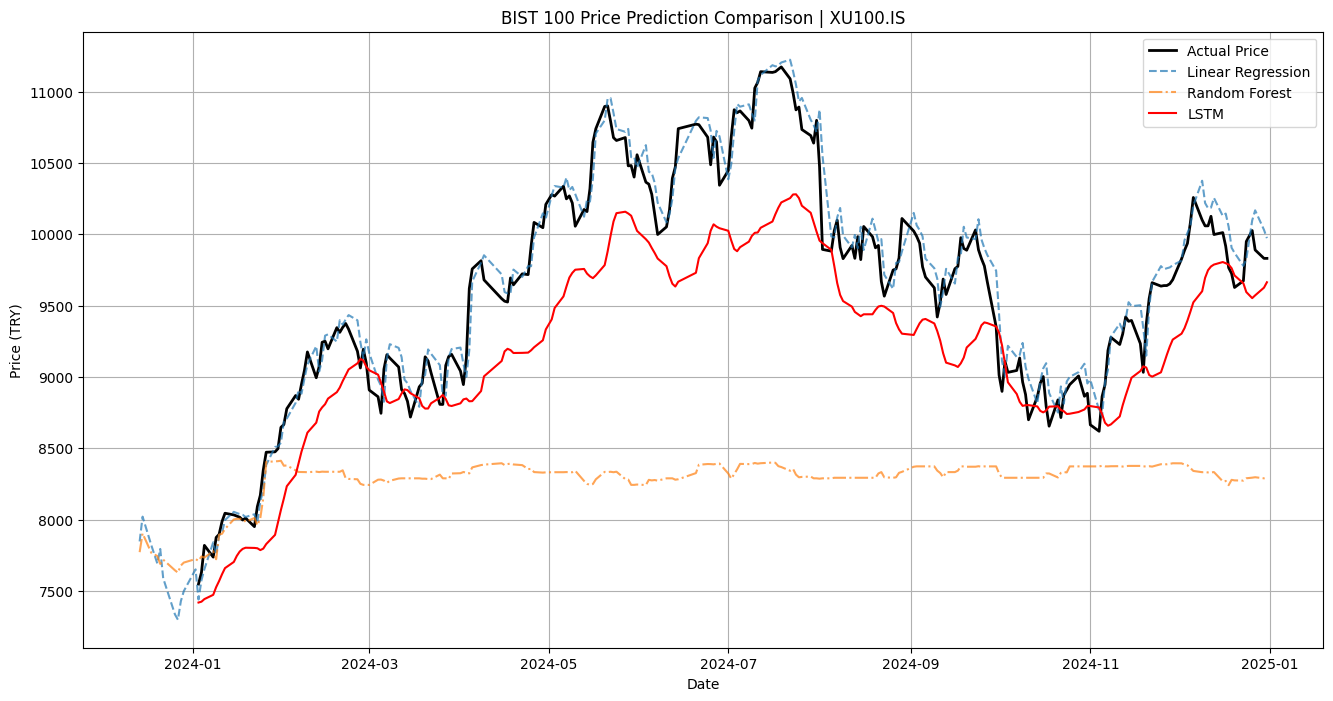

In [ ]:

print("\n--- Model Performance Metrics ---")
metrics = {}

for name in ['Linear Regression', 'Decision Tree', 'Random Forest', 'LSTM']:
    pred = predictions[name]

    if name == 'LSTM':
        y_true_scaled = y_test_lstm
    else:
        y_true_scaled = y_test

    y_true_inv = scaler_y.inverse_transform(y_true_scaled)
    y_pred_inv = scaler_y.inverse_transform(pred)

    rmse = np.sqrt(mean_squared_error(y_true_inv, y_pred_inv))
    r2 = r2_score(y_true_inv, y_pred_inv)

    metrics[name] = {
        'RMSE': rmse,
        'R2': r2,
        'Actual': y_true_inv,
        'Predicted': y_pred_inv
    }

    print(f"{name} -> RMSE: {rmse:.4f}, R2 Score: {r2:.4f}")

plt.figure(figsize=(16, 8))

lstm_start_idx = 60 + split_seq
lstm_dates = df.index[lstm_start_idx : lstm_start_idx + len(y_test_lstm)]

plt.plot(lstm_dates, metrics['LSTM']['Actual'], color='black', label='Actual Price', linewidth=2)

standard_dates = df.index[split_idx:]

plt.plot(standard_dates, metrics['Linear Regression']['Predicted'], label='Linear Regression', linestyle='--', alpha=0.7)
plt.plot(standard_dates, metrics['Random Forest']['Predicted'], label='Random Forest', linestyle='-.', alpha=0.7)

plt.plot(lstm_dates, metrics['LSTM']['Predicted'], label='LSTM', color='red', linewidth=1.5)

plt.title(f'BIST 100 Price Prediction Comparison | {ticker}')
plt.xlabel('Date')
plt.ylabel('Price (TRY)')
plt.legend()
plt.grid(True)
plt.show()

OVERALL VISUALIZATON PICTURE FROM PAPER.

WİTH HELP OF THAT PICTURE WE CAN SEE THE DIFFERANCES.

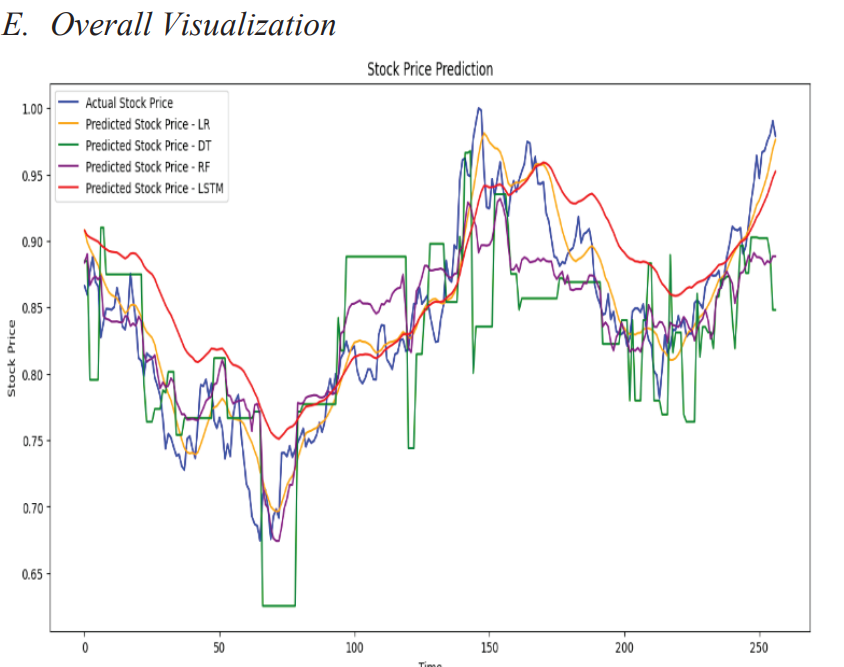